## import

In [119]:
import pandas as pd
import numpy as np
import scipy as sp
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.table import Table
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
#colors = sns.color_palette("colorblind").as_hex()
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

## explore CMB maps

In [120]:
# define paths to datafiles
map_hm1 = 'data/HFI_SkyMap_143_2048_R3.01_halfmission-1.fits'              # map for half mission 1 143 GHZ
map_hm2 = 'data/HFI_SkyMap_143_2048_R3.01_halfmission-2.fits'
mask_gp = 'data/HFI_Mask_GalPlane-apo5_2048_R2.00.fits'              # galactic plane mask
mask_ps = 'data/HFI_Mask_PointSrc_2048_R2.00.fits'                   # mask point source

# extract primary headers in each fits file
primary_hdus = []
event_hdus = []

for item in [map_hm1, map_hm2, mask_gp, mask_ps]:
    # open each file, print important info, and extract primary data
    hdul_i = fits.open(item)
    hdul_i.info()
    print('='*90)
    
    events = Table.read(map_hm1, hdu=1)
    second_hdus.append(hdul_i[1].data)

Filename: data/HFI_SkyMap_143_2048_R3.01_halfmission-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  FREQ-MAP      1 BinTableHDU     75   50331648R x 10C   [E, E, E, J, E, E, E, E, E, E]   
Filename: data/HFI_SkyMap_143_2048_R3.01_halfmission-2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  FREQ-MAP      1 BinTableHDU     75   50331648R x 10C   [E, E, E, J, E, E, E, E, E, E]   
Filename: data/HFI_Mask_GalPlane-apo5_2048_R2.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GAL-MASK      1 BinTableHDU     54   50331648R x 8C   [E, E, E, E, E, E, E, E]   
Filename: data/HFI_Mask_PointSrc_2048_R2.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SRC-INT       1 BinTableHDU     49   50331648

In [121]:
(event_hdus[0].columns)

IndexError: list index out of range

In [44]:
test_array = np.array(scidata_m1[0:10])
type(test_array[0])

numpy.record

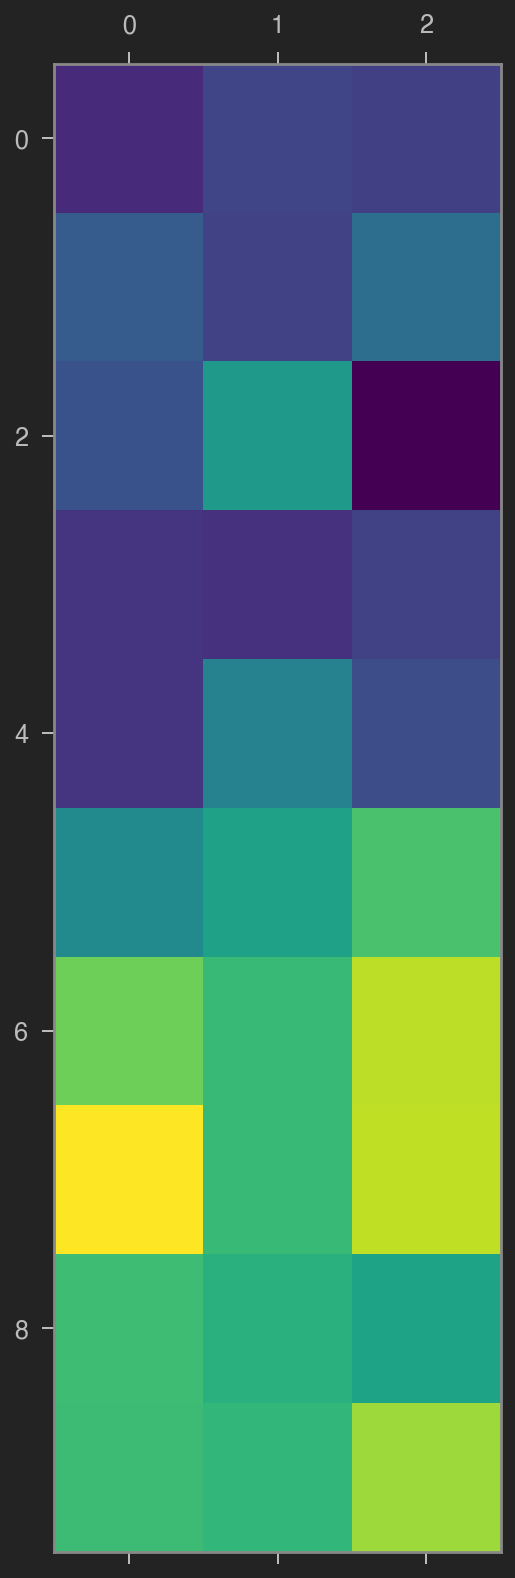

In [64]:
plt.matshow(scidata_m1['I_STOKES'].reshape(50331648//3, 3)[:10,0:3])
plt.show()

In [59]:
test = scidata_m1['I_STOKES'].reshape(50331648//3, 3)[:,0:2]
print(np.max(test))

0.009951804
